In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from pylab import rcParams

In [3]:
df = pd.read_csv('data.csv')
df

,SALE_DT,STORE,SALES
0,2019-01-01 00:00:00.000,Store_a,0.00
1,2019-01-02 00:00:00.000,Store_a,16553359.58
2,2019-01-03 00:00:00.000,Store_a,17956624.58
3,2019-01-04 00:00:00.000,Store_a,19440652.23
4,2019-01-05 00:00:00.000,Store_a,20677704.73
...,...,...,...
1272,2022-06-26 00:00:00.000,Store_a,17243093.78
1273,2022-06-27 00:00:00.000,Store_a,13538082.87
1274,2022-06-28 00:00:00.000,Store_a,13565274.83
1275,2022-06-29 00:00:00.000,Store_a,14959597.22


In [4]:
df.isnull().sum()

SALE_DT    0
STORE      0
SALES      0
dtype: int64

In [5]:
df.columns = ['date', 'store','sales']
df.head()

,date,store,sales
0,2019-01-01 00:00:00.000,Store_a,0.00
1,2019-01-02 00:00:00.000,Store_a,16553359.58
2,2019-01-03 00:00:00.000,Store_a,17956624.58
3,2019-01-04 00:00:00.000,Store_a,19440652.23
4,2019-01-05 00:00:00.000,Store_a,20677704.73


In [6]:
df['sales'] = df['sales'].astype('int64')

In [7]:
df.head()

,date,store,sales
0,2019-01-01 00:00:00.000,Store_a,0
1,2019-01-02 00:00:00.000,Store_a,16553359
2,2019-01-03 00:00:00.000,Store_a,17956624
3,2019-01-04 00:00:00.000,Store_a,19440652
4,2019-01-05 00:00:00.000,Store_a,20677704


In [8]:
df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,store,sales
1272,2022-06-26,Store_a,17243093
1273,2022-06-27,Store_a,13538082
1274,2022-06-28,Store_a,13565274
1275,2022-06-29,Store_a,14959597
1276,2022-06-30,Store_a,15852066


In [9]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
# df = df[df['store'] == 'Store_a']
# df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2022-03-29'].reset_index(drop=False)
test_df = temp_df.loc['2022-03-30':].reset_index(drop=False)

train_df.head()

,date,store,sales,year,month,day,weekday
0,2019-01-01,Store_a,0,2019,1,1,1
1,2019-01-02,Store_a,16553359,2019,1,2,2
2,2019-01-03,Store_a,17956624,2019,1,3,3
3,2019-01-04,Store_a,19440652,2019,1,4,4
4,2019-01-05,Store_a,20677704,2019,1,5,5


In [10]:
test_df.head()

,date,store,sales,year,month,day,weekday
0,2022-03-30,Store_a,16866139,2022,3,30,2
1,2022-03-31,Store_a,18653304,2022,3,31,3
2,2022-04-01,Store_a,22145437,2022,4,1,4
3,2022-04-02,Store_a,28433668,2022,4,2,5
4,2022-04-03,Store_a,22556098,2022,4,3,6


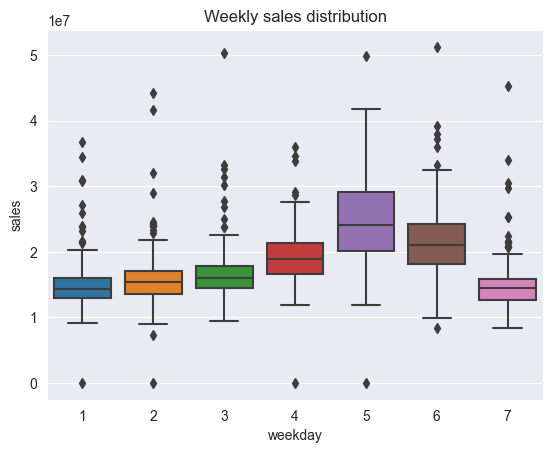

In [11]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

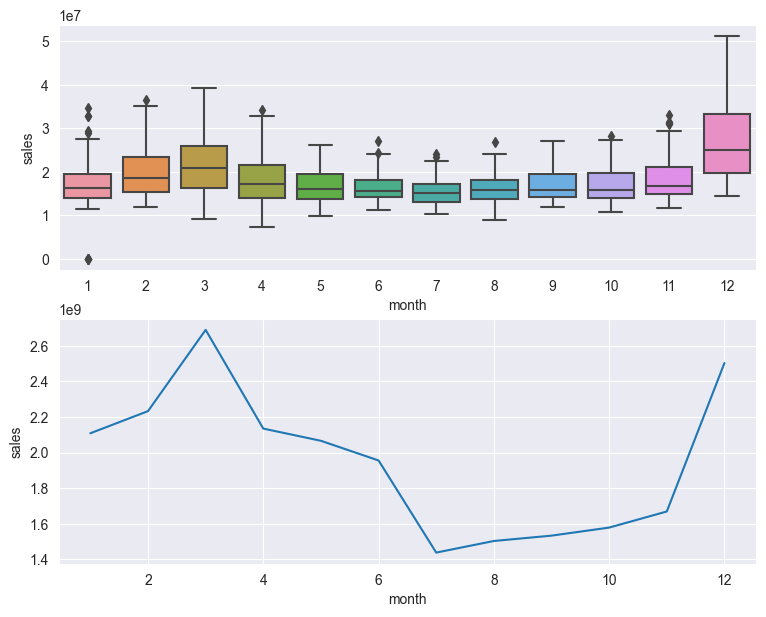

In [12]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

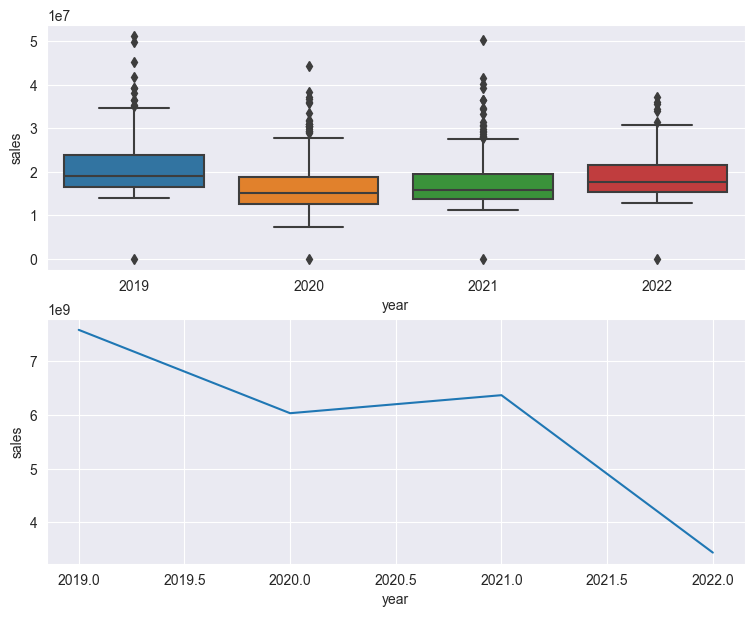

In [13]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

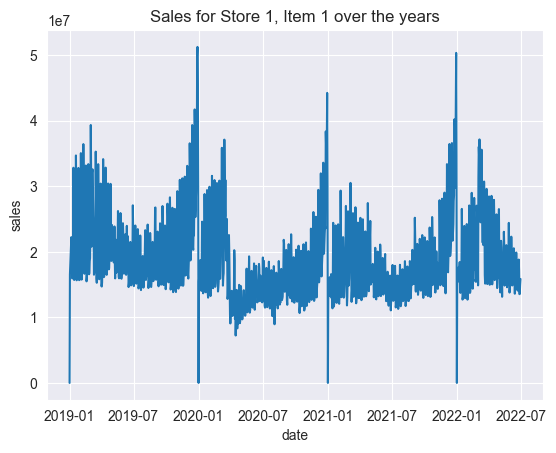

In [14]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [15]:
y = df[['date', 'sales']].copy()
y.tail()

,date,sales
1272,2022-06-26,17243093
1273,2022-06-27,13538082
1274,2022-06-28,13565274
1275,2022-06-29,14959597
1276,2022-06-30,15852066


In [16]:
y['date'] = pd.to_datetime(df['date'])
df.head()

,date,store,sales,year,month,day,weekday
0,2019-01-01,Store_a,0,2019,1,1,1
1,2019-01-02,Store_a,16553359,2019,1,2,2
2,2019-01-03,Store_a,17956624,2019,1,3,3
3,2019-01-04,Store_a,19440652,2019,1,4,4
4,2019-01-05,Store_a,20677704,2019,1,5,5


In [17]:
y.set_index('date', inplace=True)
y.tail()

,sales
date,
2022-06-26,17243093
2022-06-27,13538082
2022-06-28,13565274
2022-06-29,14959597
2022-06-30,15852066


In [18]:
y = y['sales'].resample('MS').mean()

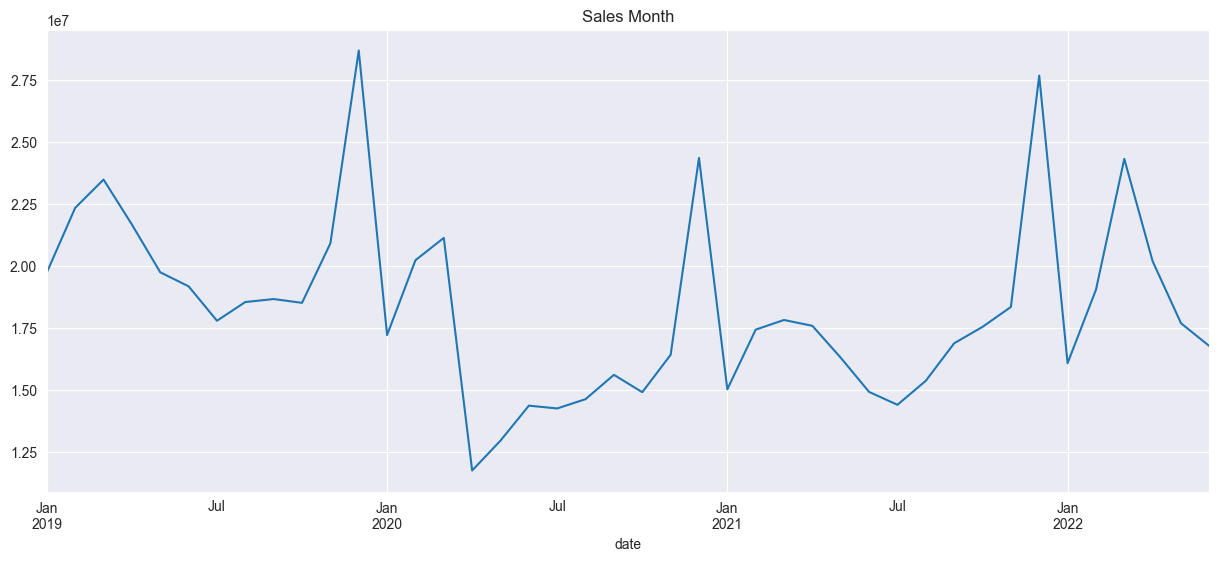

In [19]:
y.plot(figsize=(15, 6), title='Sales Month')
plt.show()

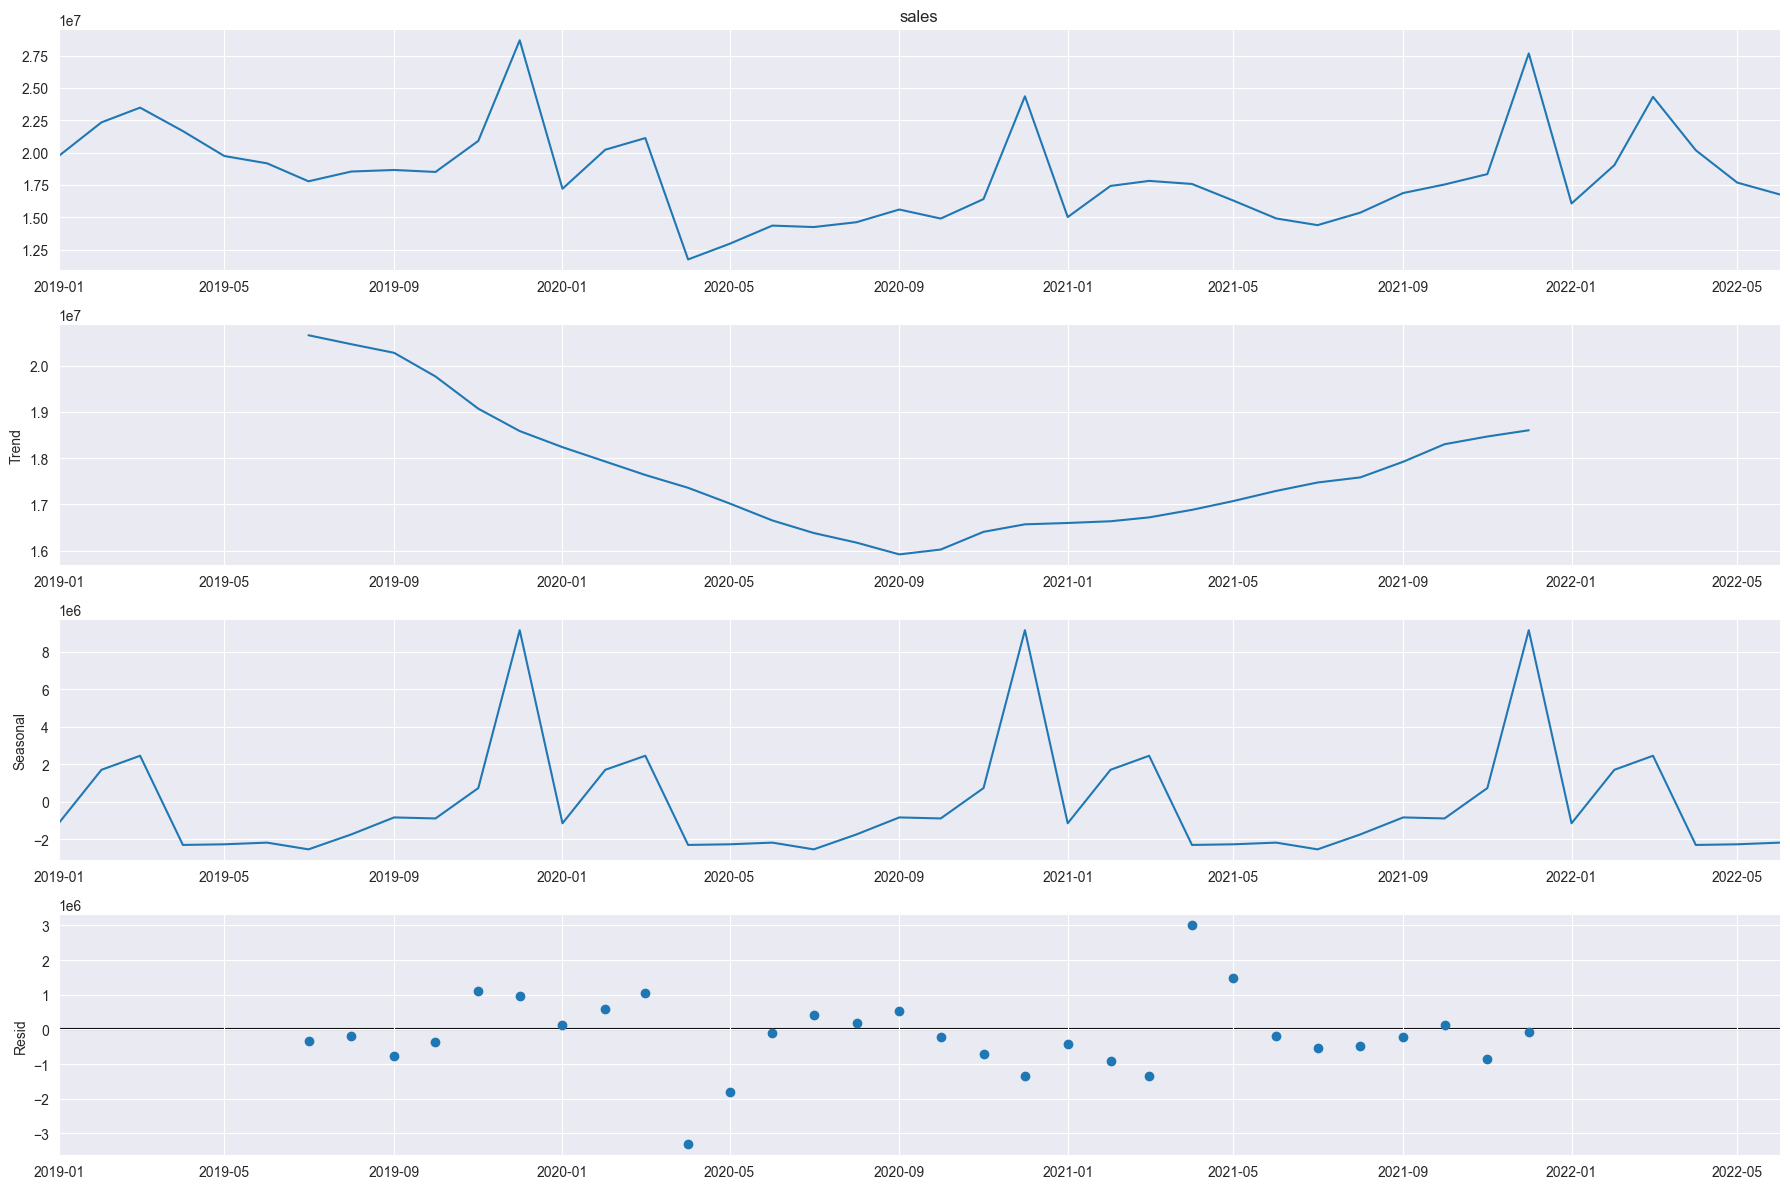

In [20]:
rcParams['figure.figsize'] = 18, 12

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [21]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0938      1.161      0.081      0.936      -2.181       2.369
ma.L1         -0.1672      1.152     -0.145      0.885      -2.425       2.091
ar.S.L12      -0.2048      0.548     -0.374      0.708      -1.278       0.869
ma.S.L12       0.0541      0.580      0.093      0.926      -1.082       1.191
sigma2      5.766e+12    2.2e-12   2.62e+24      0.000    5.77e+12    5.77e+12


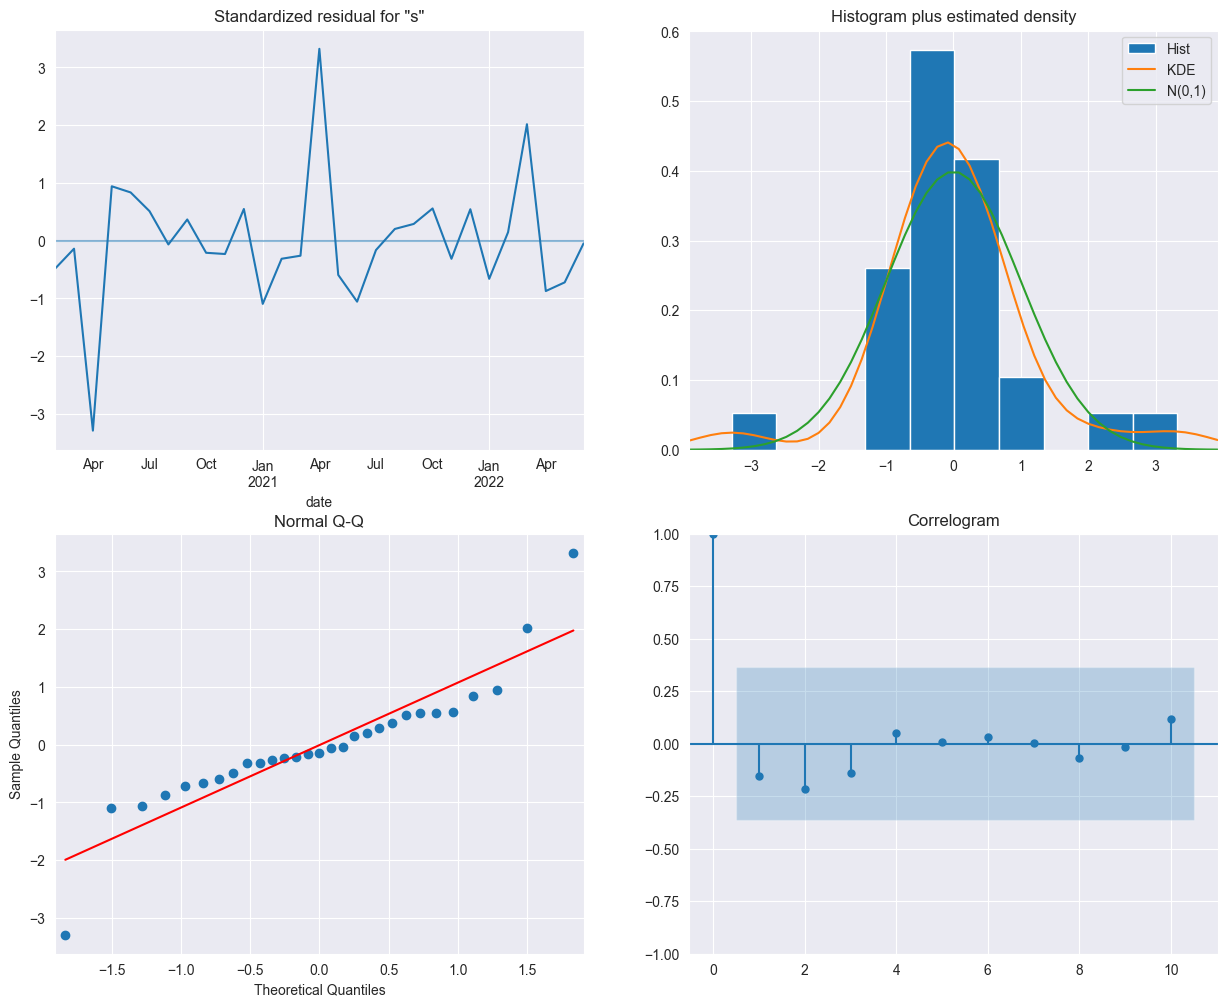

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

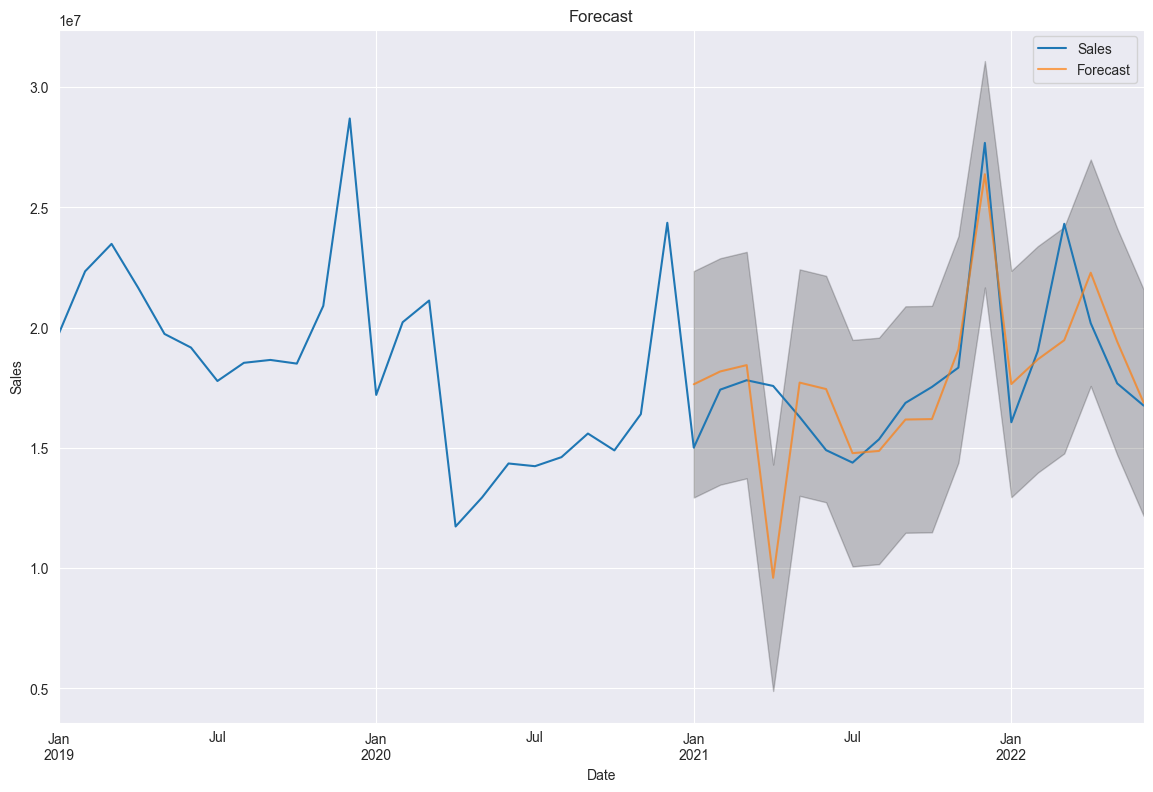

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2019':].plot(label='Sales')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 9), title='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

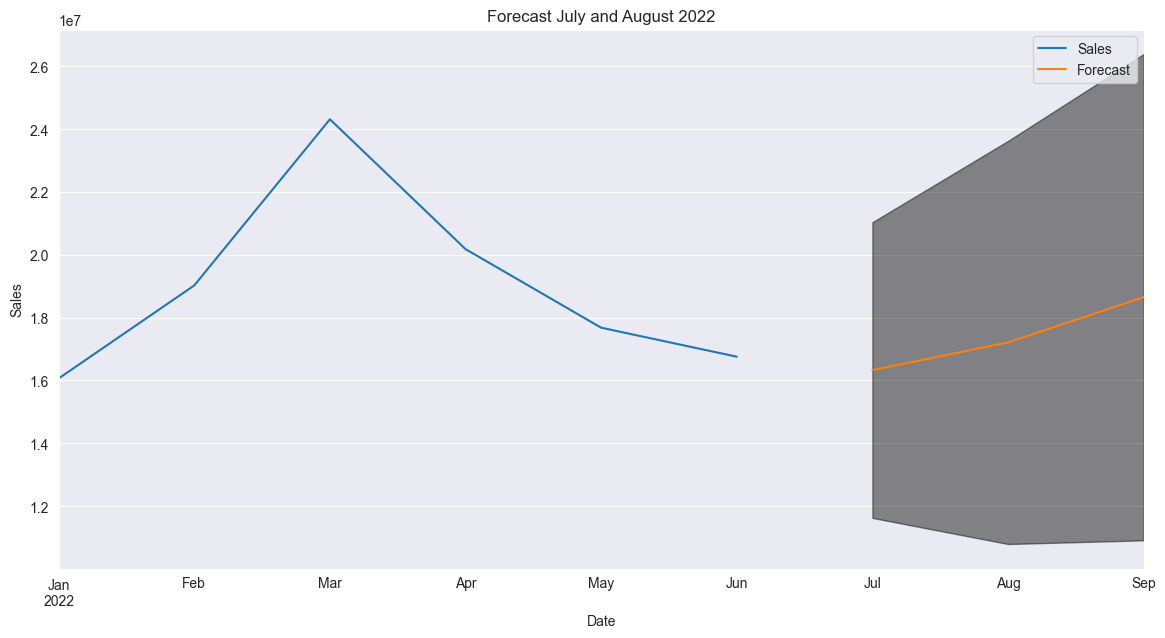

In [24]:
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()



ax = y['2022'].plot(label='Sales', figsize=(14, 7), title='Forecast July and August 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.45)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

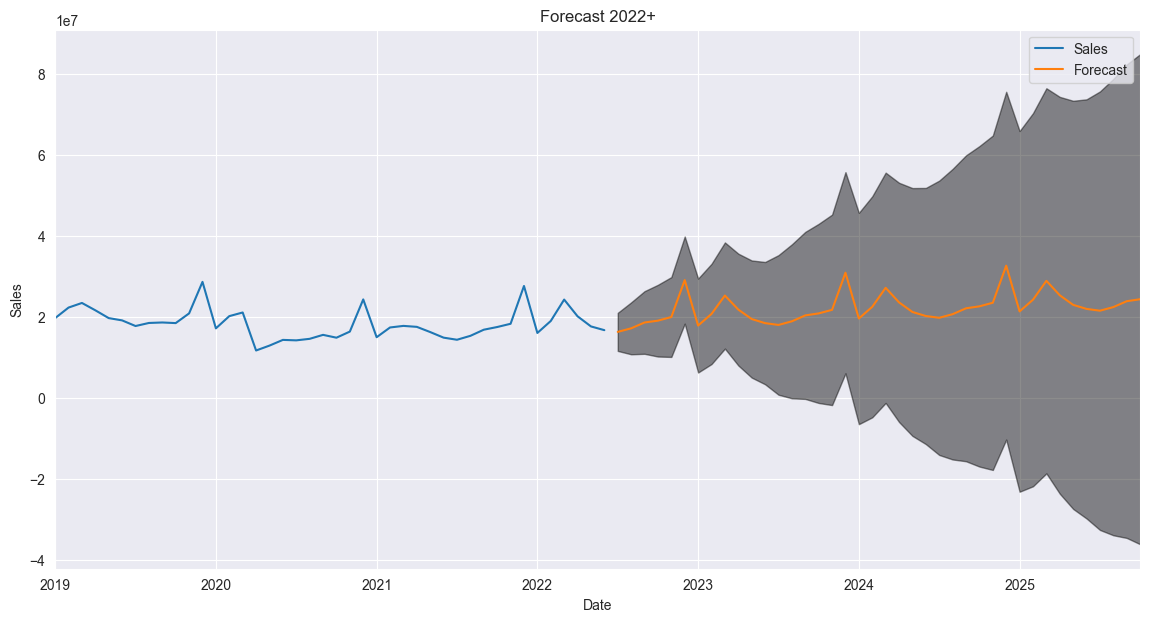

In [25]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Sales', figsize=(14, 7), title='Forecast 2022+')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.45)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

## 1. Baseline Model: Seasonal Naive

In [26]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D'))
seasonal_naive_sales = train_df[train_df['date'].isin(dates)]['sales']

## make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,year,month,day,weekday,seasonal_naive_sales
0,2022-03-30,Store_a,2022,3,30,2,12976370
1,2022-03-31,Store_a,2022,3,31,3,14436502
2,2022-04-01,Store_a,2022,4,1,4,18519502
3,2022-04-02,Store_a,2022,4,2,5,25172470
4,2022-04-03,Store_a,2022,4,3,6,20964365


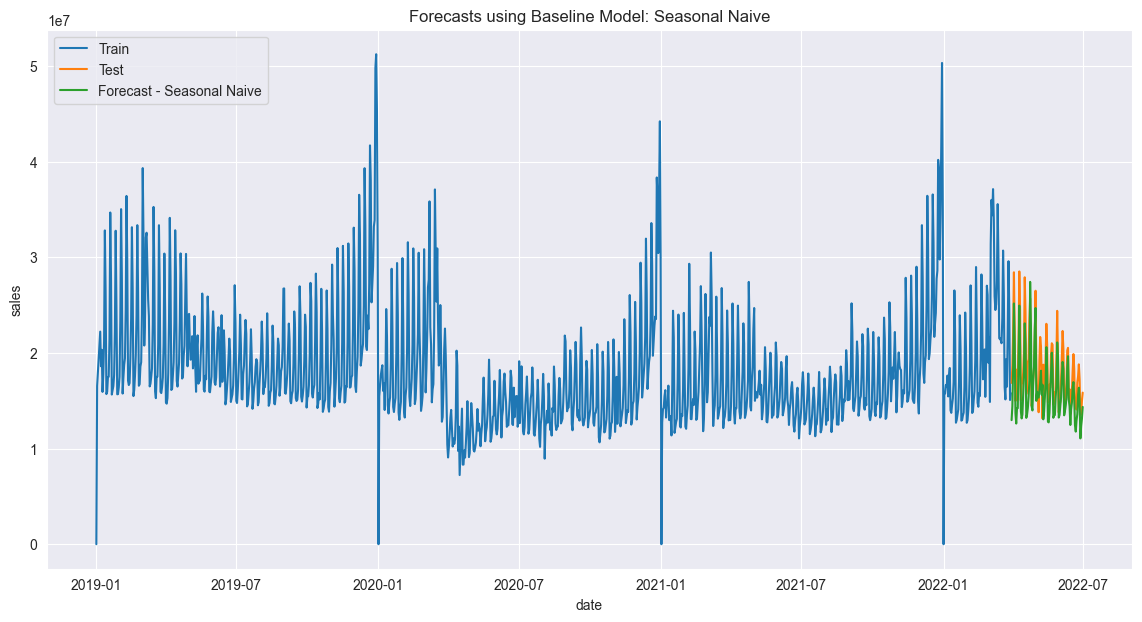

In [27]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

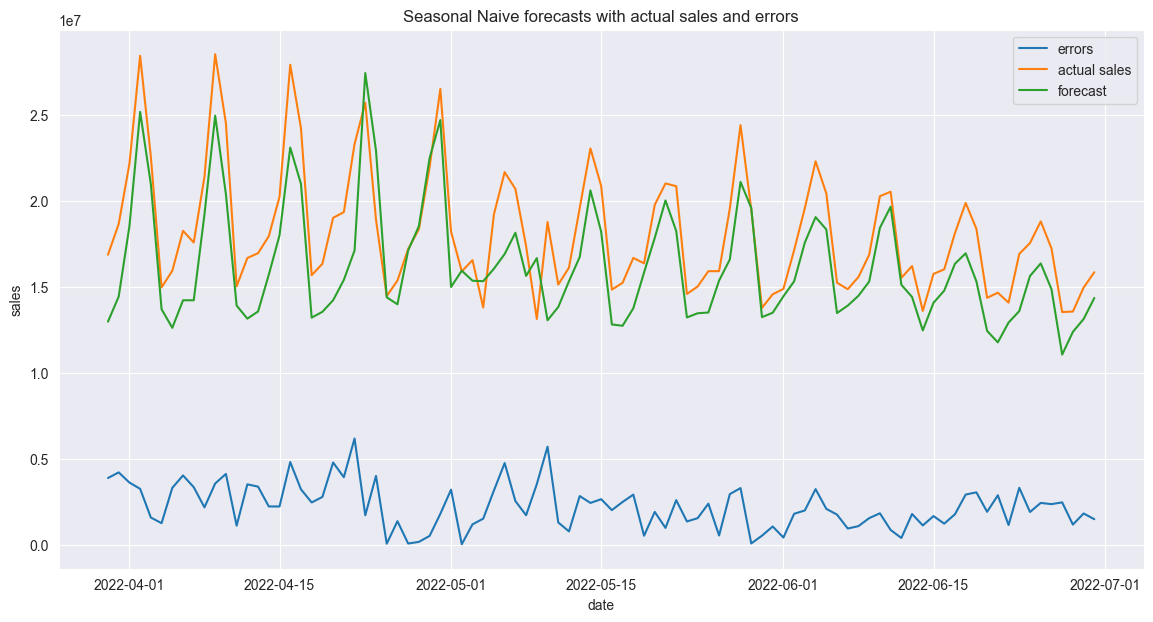

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1691729695,1506561921,185167774,2.241222e+06,2.586054e+06,12.320742


In [28]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

In [29]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,sales,year,month,day,weekday
date,,,,,,
2019-01-01,Store_a,0.0,2019,1,1,1
2019-01-02,Store_a,16553359.0,2019,1,2,2
2019-01-03,Store_a,17956624.0,2019,1,3,3
2019-01-04,Store_a,19440652.0,2019,1,4,4
2019-01-05,Store_a,20677704.0,2019,1,5,5


<Figure size 1800x1200 with 0 Axes>

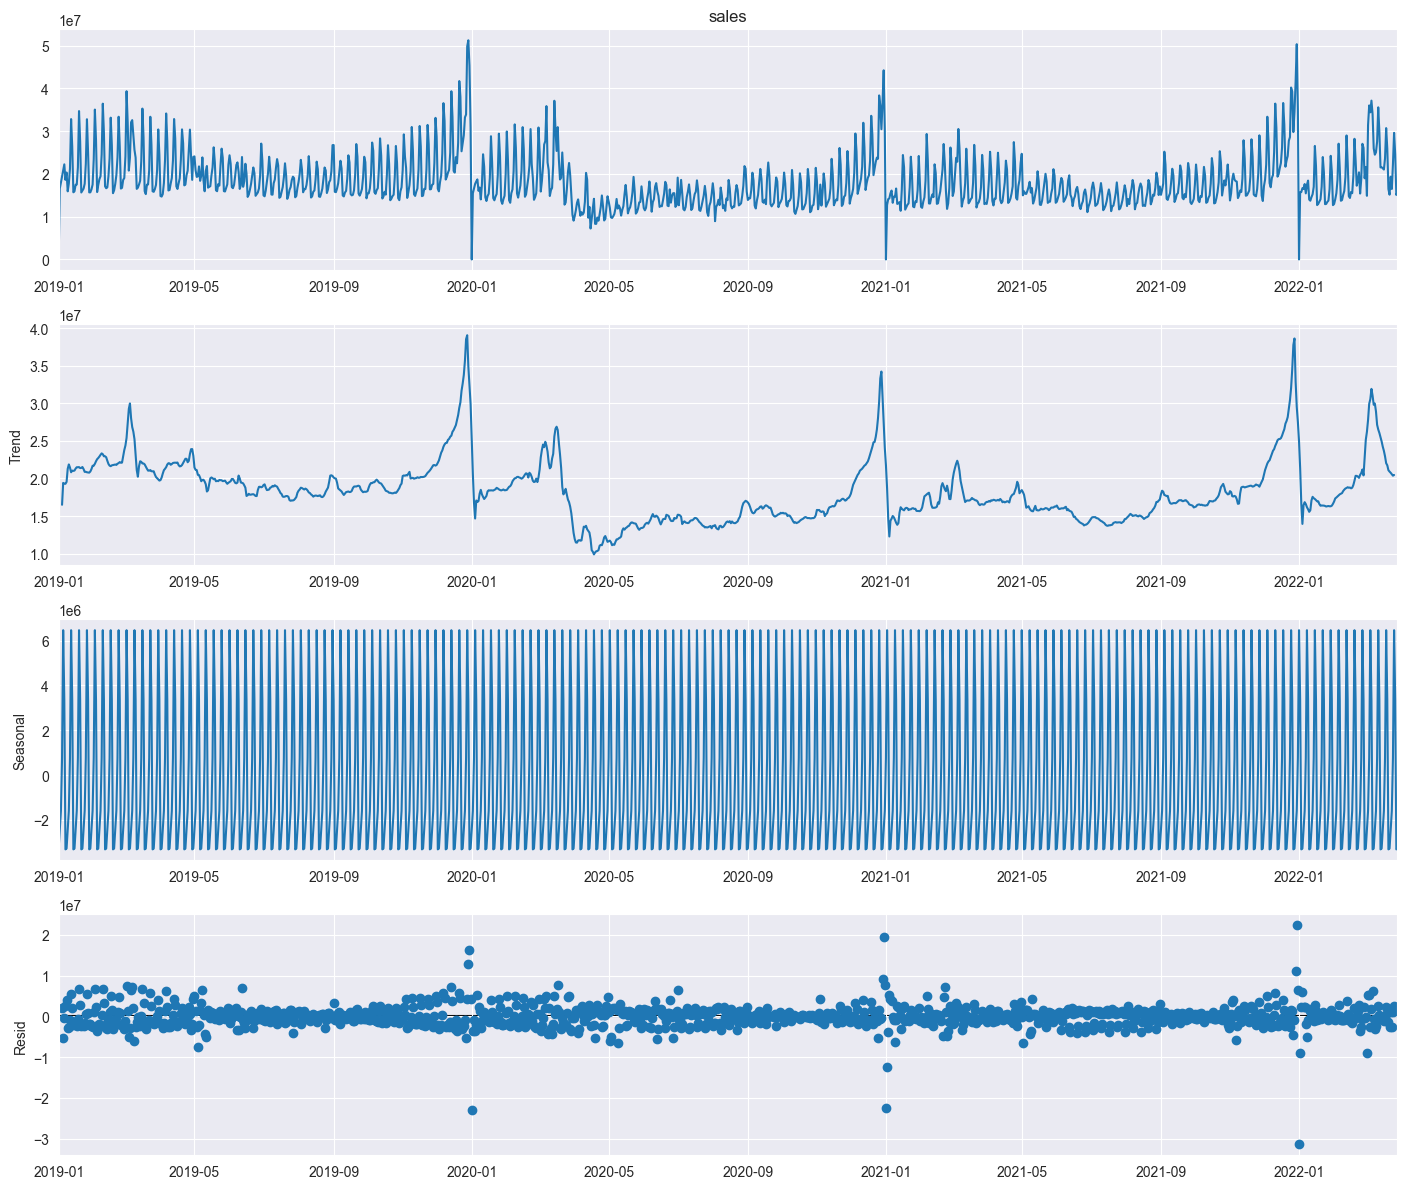

In [30]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive')
# result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

## 2. Holt Winter's Triple Exponential Smoothing Model

In [31]:
from statsmodels.tools.sm_exceptions import  ValueWarning
warnings.simplefilter('ignore', ValueWarning)
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit()
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit()
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


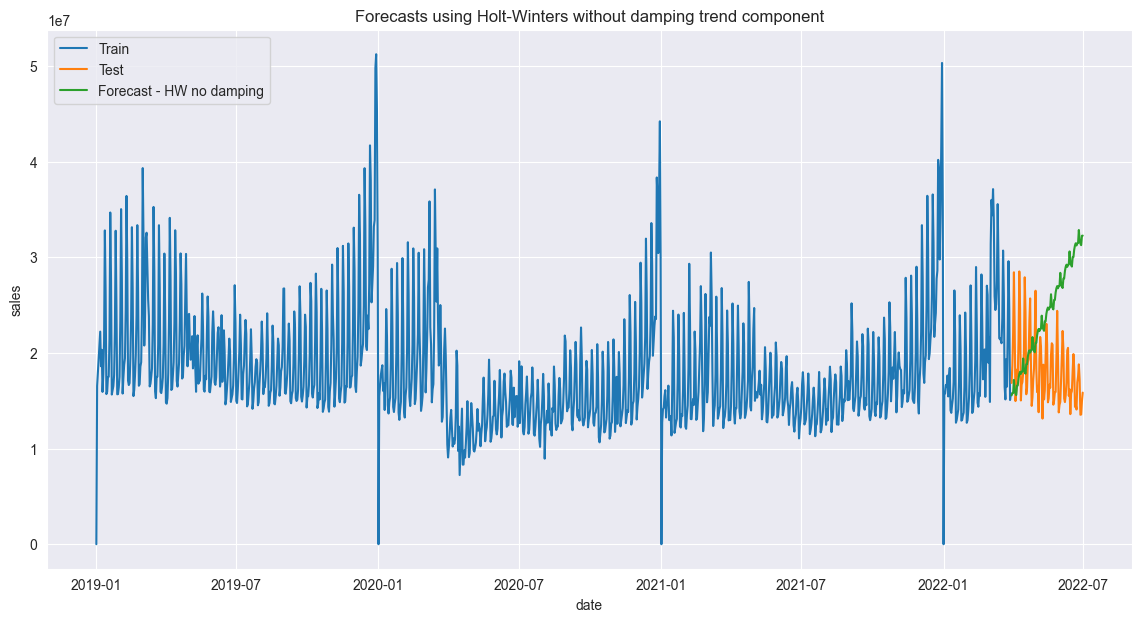

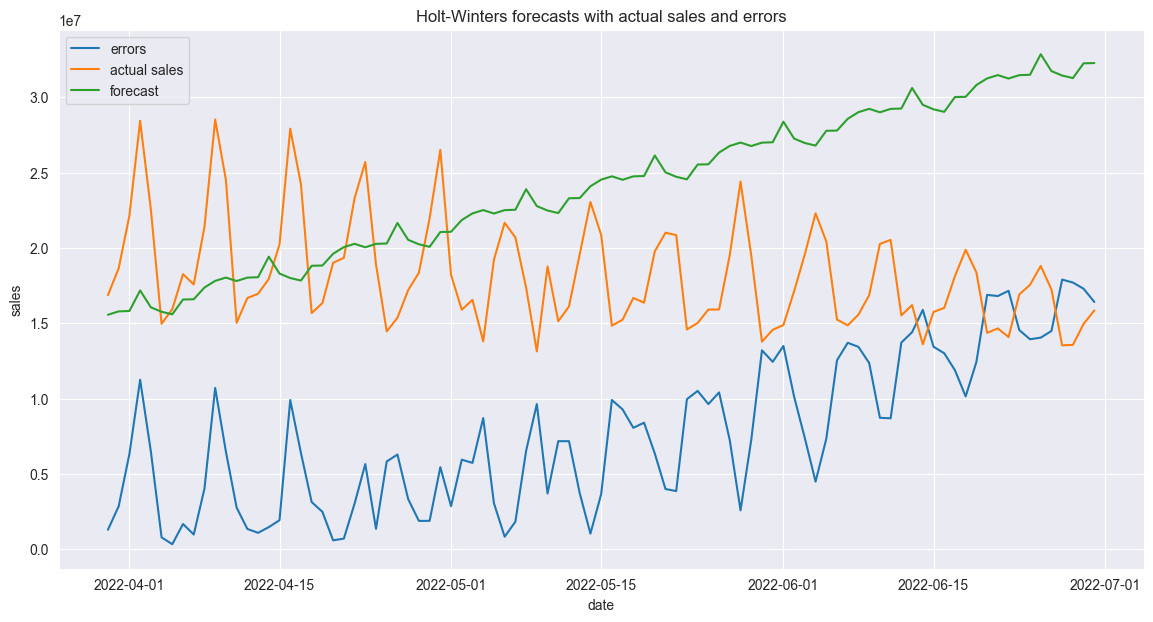

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1691729695,2.237389e+09,-5.456598e+08,7.732293e+06,9.240768e+06,42.506984


In [32]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hw

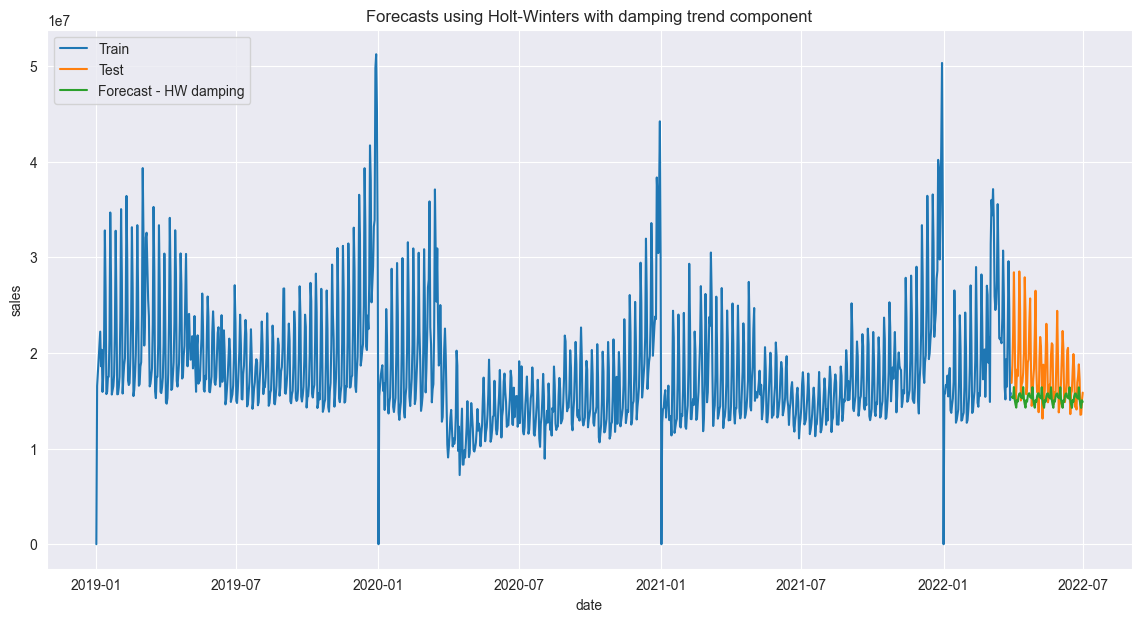

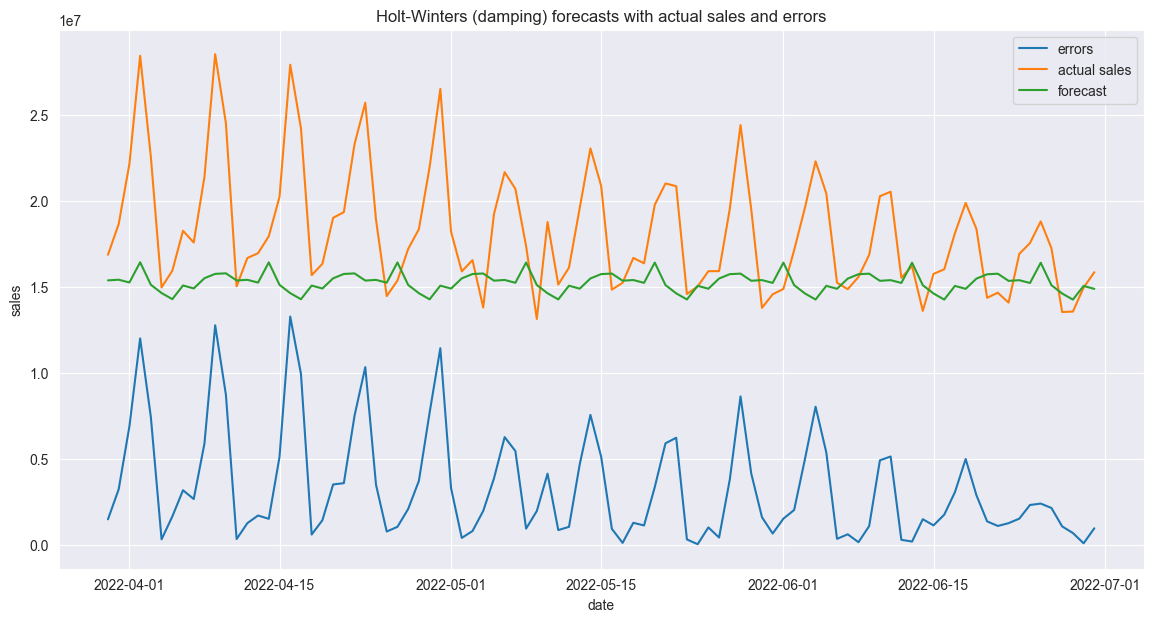

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1691729695,1.420095e+09,2.716347e+08,3.331439e+06,4.584604e+06,18.314025


In [33]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hwd

## 3. Autoregressive Integrated Moving Average - ARIMA Model

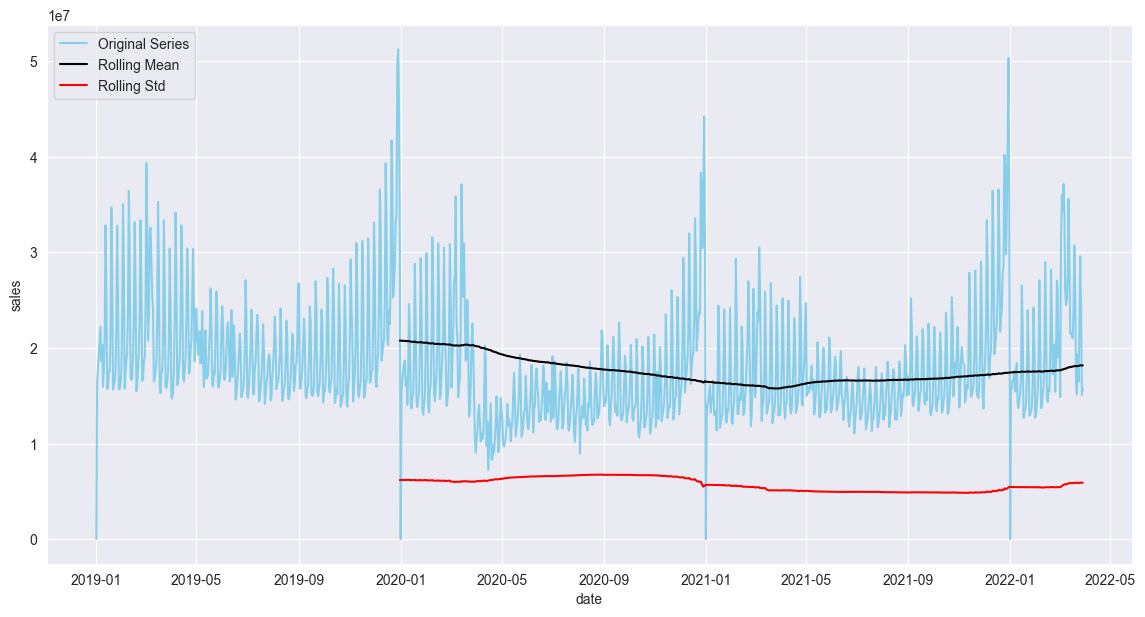

Test statistic = -4.153
P-value = 0.001
Critical values :
	1%: -3.4359901072390353 - The data is  stationary with 99% confidence
	5%: -2.86403051064684 - The data is  stationary with 95% confidence
	10%: -2.5680960046332366 - The data is  stationary with 90% confidence


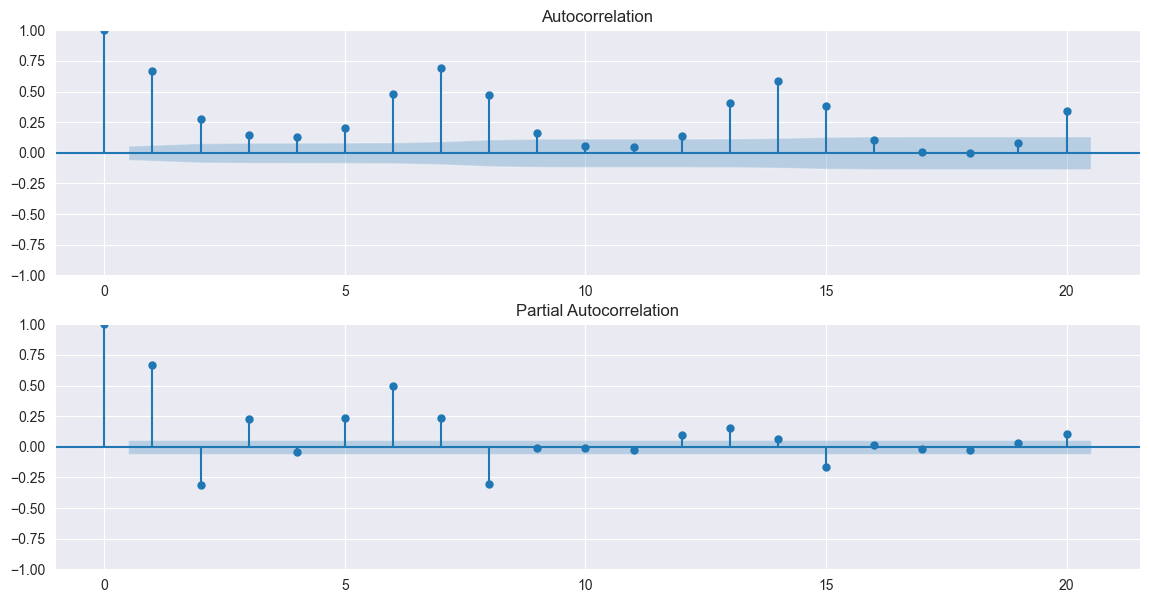

In [34]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.sales)

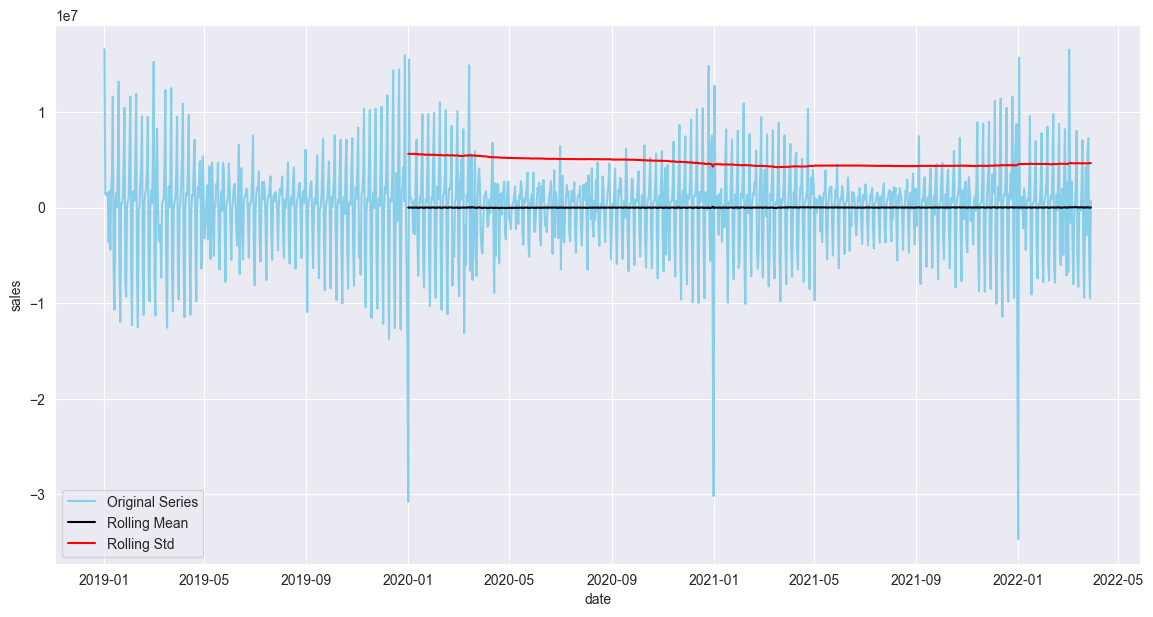

Test statistic = -9.709
P-value = 0.000
Critical values :
	1%: -3.4359901072390353 - The data is  stationary with 99% confidence
	5%: -2.86403051064684 - The data is  stationary with 95% confidence
	10%: -2.5680960046332366 - The data is  stationary with 90% confidence


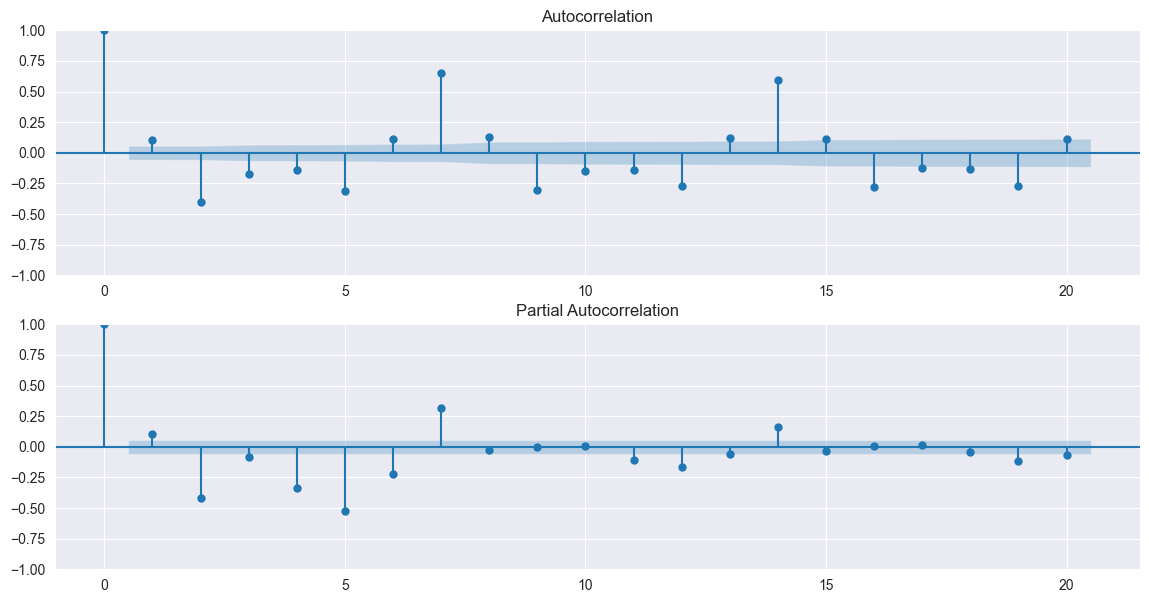

In [35]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

In [36]:
# arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
# print(arima_model61.summary())

In [37]:
arima_model61 = ARIMA(arima_df.sales, order=(6,1,1))
arima_model61 = arima_model61.fit()
print(arima_model61.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1184
Model:                 ARIMA(6, 1, 1)   Log Likelihood              -19446.908
Date:                Tue, 02 May 2023   AIC                          38909.816
Time:                        10:24:09   BIC                          38950.422
Sample:                    01-01-2019   HQIC                         38925.123
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7453      0.044    -16.954      0.000      -0.831      -0.659
ar.L2         -0.7067      0.020    -35.164      0.000      -0.746      -0.667
ar.L3         -0.7227      0.029    -24.522      0.0

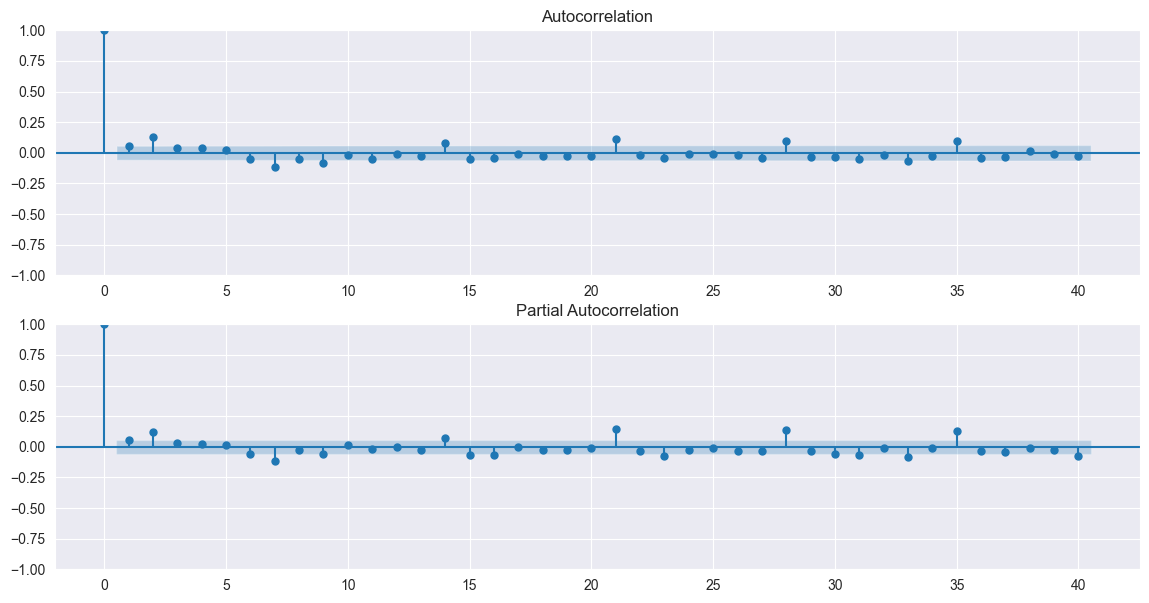

In [38]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

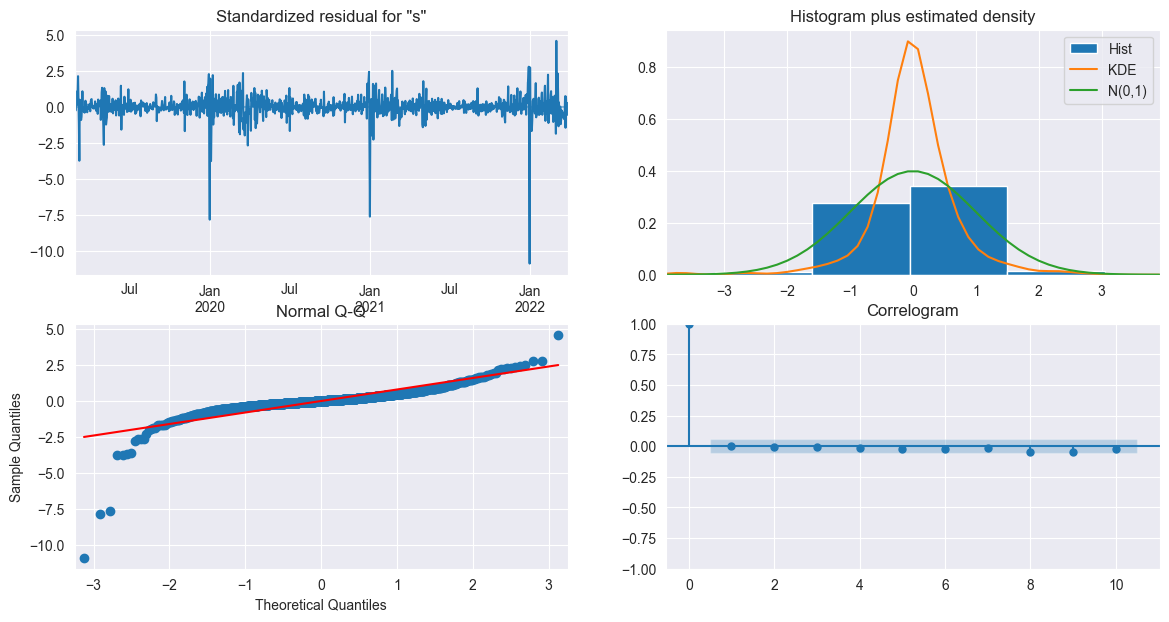

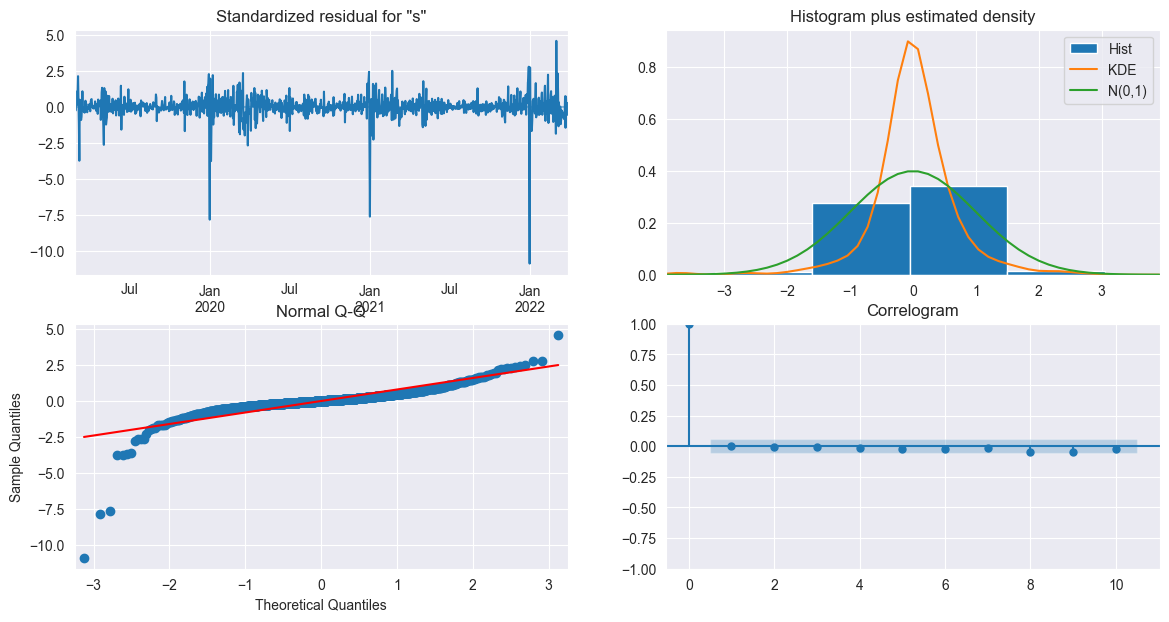

In [39]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

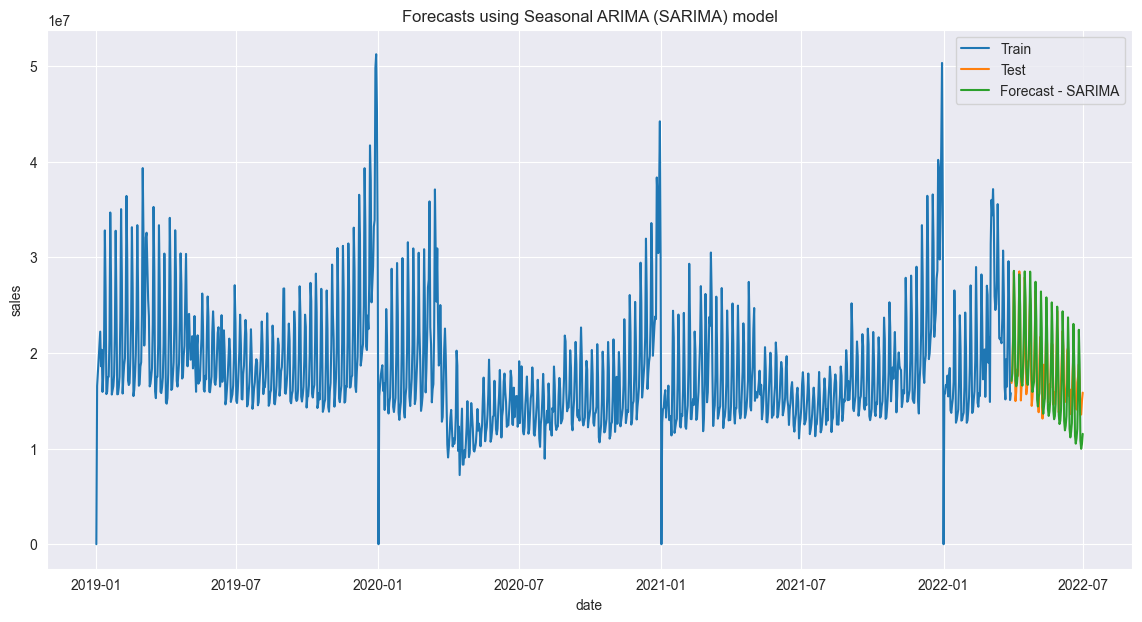

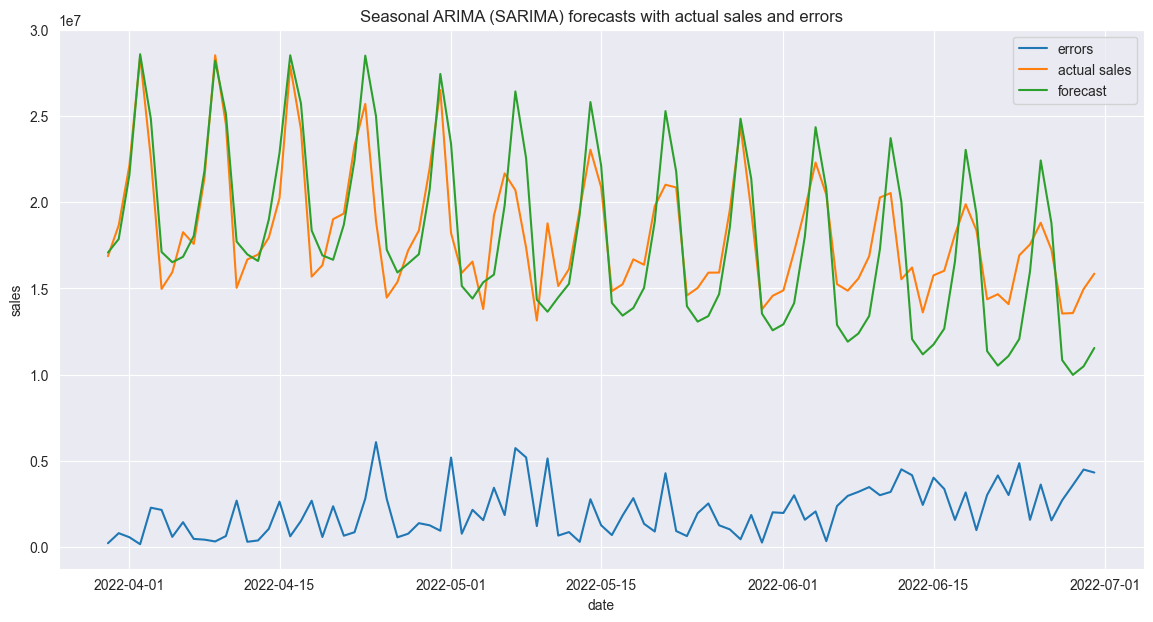

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1691729695,1.661746e+09,2.998345e+07,2.079517e+06,2.541701e+06,11.431797


In [40]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_sarima

In [41]:
reg_df = df
reg_df

,date,store,sales,year,month,day,weekday
0,2019-01-01,Store_a,0,2019,1,1,1
1,2019-01-02,Store_a,16553359,2019,1,2,2
2,2019-01-03,Store_a,17956624,2019,1,3,3
3,2019-01-04,Store_a,19440652,2019,1,4,4
4,2019-01-05,Store_a,20677704,2019,1,5,5
...,...,...,...,...,...,...,...
1272,2022-06-26,Store_a,17243093,2022,6,26,6
1273,2022-06-27,Store_a,13538082,2022,6,27,7
1274,2022-06-28,Store_a,13565274,2022,6,28,1
1275,2022-06-29,Store_a,14959597,2022,6,29,2


In [42]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()


# reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date',inplace=False)
reg_train_df = reg_df.loc[:'2022-03-29']
reg_test_df = reg_df.loc['2022-03-30':]

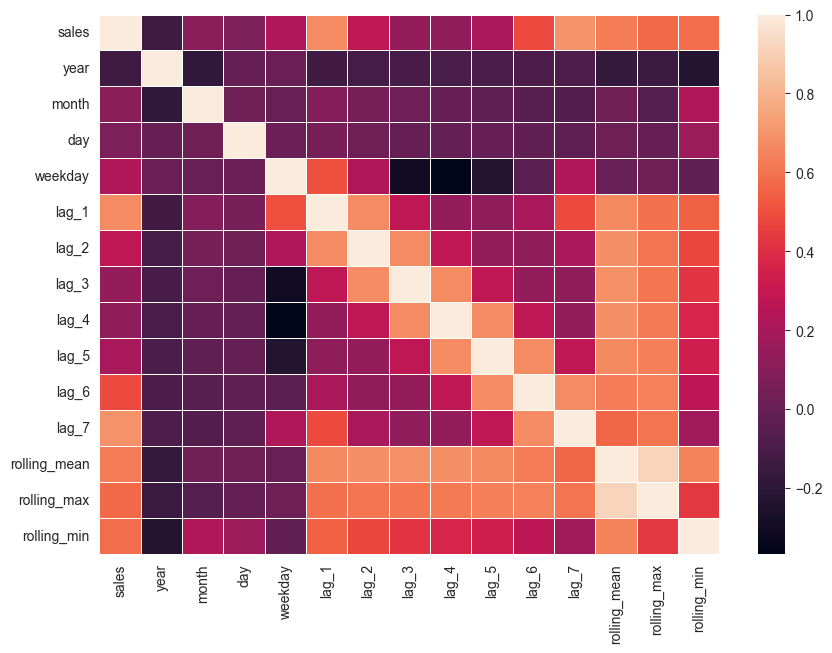

In [43]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [44]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values



# Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_test, y_test)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)
#
# concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature       Score
10         lag_7  338.553097
9          lag_6   30.415680
4          lag_1   29.138657
11  rolling_mean   17.681599
12   rolling_max   14.946177


In [45]:
X_train

,year,month,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,,
2019-01-01,2019,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,2019,1,2,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2019,1,3,3,16553359.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2019,1,4,4,17956624.0,16553359.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,2019,1,5,5,19440652.0,17956624.0,16553359.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,2022,3,25,4,16474149.0,19345334.0,15142244.0,16448110.0,25890815.0,30705479.0,23645328.0,2.090501e+07,30705479.0,15142244.0
2022-03-26,2022,3,26,5,22328937.0,16474149.0,19345334.0,15142244.0,16448110.0,25890815.0,30705479.0,2.074554e+07,29589192.0,15142244.0
2022-03-27,2022,3,27,6,29589192.0,22328937.0,16474149.0,19345334.0,15142244.0,16448110.0,25890815.0,2.055824e+07,29589192.0,15142244.0


In [46]:
X_test

,year,month,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,,
2022-03-30,2022,3,30,2,15796594.0,15078616.0,24579735.0,29589192.0,22328937.0,16474149.0,19345334.0,2.010191e+07,29589192.0,15078616.0
2022-03-31,2022,3,31,3,16866139.0,15796594.0,15078616.0,24579735.0,29589192.0,22328937.0,16474149.0,2.041322e+07,29589192.0,15078616.0
2022-04-01,2022,4,1,4,18653304.0,16866139.0,15796594.0,15078616.0,24579735.0,29589192.0,22328937.0,2.038700e+07,29589192.0,15078616.0
2022-04-02,2022,4,2,5,22145437.0,18653304.0,16866139.0,15796594.0,15078616.0,24579735.0,29589192.0,2.022193e+07,28433668.0,15078616.0
2022-04-03,2022,4,3,6,28433668.0,22145437.0,18653304.0,16866139.0,15796594.0,15078616.0,24579735.0,1.993284e+07,28433668.0,15078616.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,2022,6,26,6,18806041.0,17548366.0,16916497.0,14083730.0,14660752.0,14363852.0,18373593.0,1.623176e+07,18806041.0,14083730.0
2022-06-27,2022,6,27,7,17243093.0,18806041.0,17548366.0,16916497.0,14083730.0,14660752.0,14363852.0,1.611379e+07,18806041.0,13538082.0
2022-06-28,2022,6,28,1,13538082.0,17243093.0,18806041.0,17548366.0,16916497.0,14083730.0,14660752.0,1.595730e+07,18806041.0,13538082.0


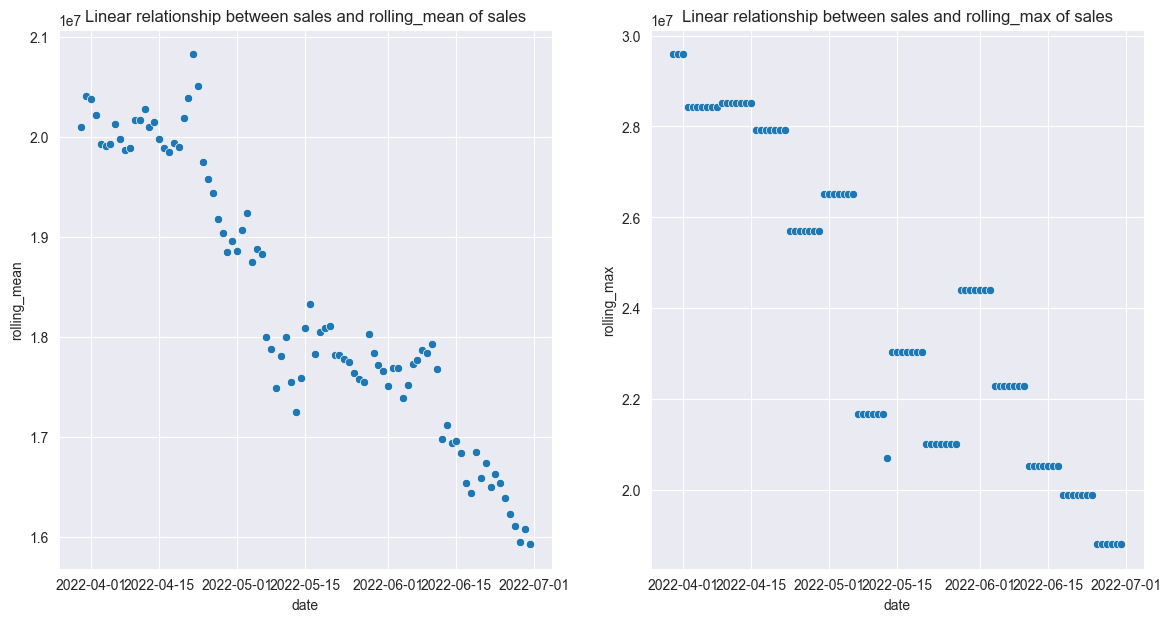

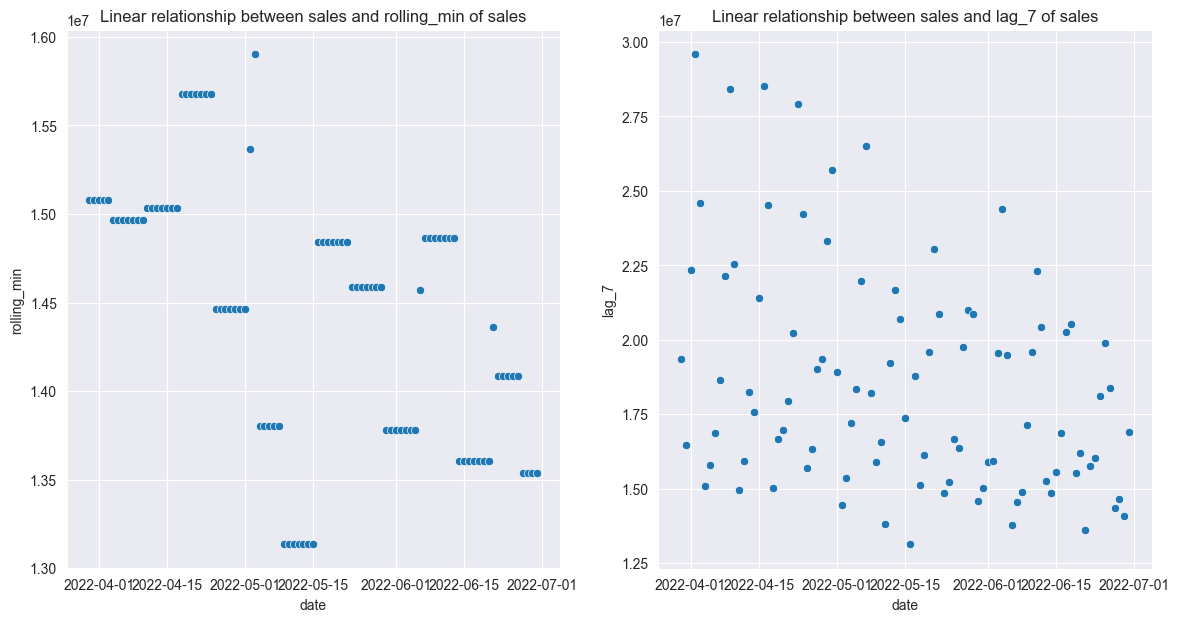

In [47]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_test_df.rolling_mean,  ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_test_df.rolling_max, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_test_df.rolling_min, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_test_df.lag_7,  ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [48]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_test, y_test)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

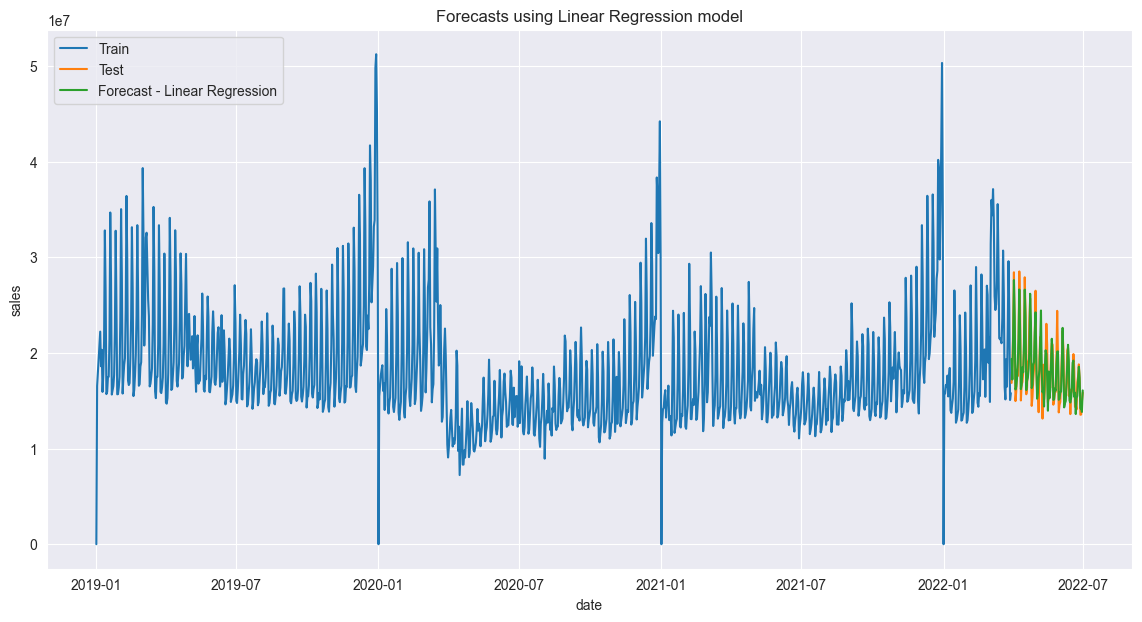

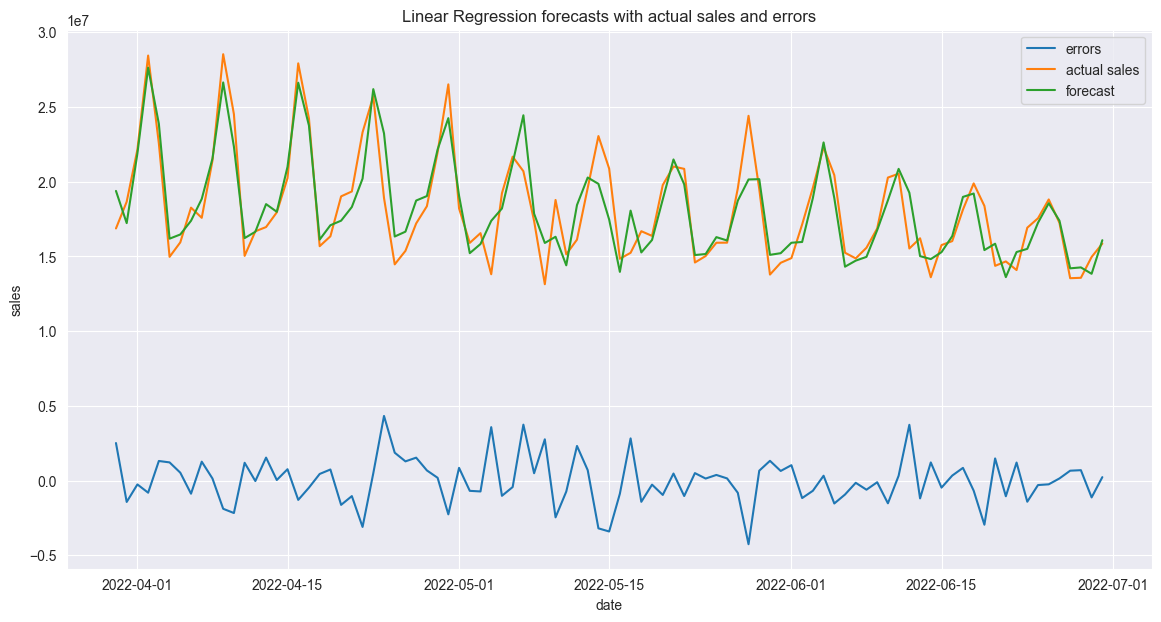

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1691729695,1.691730e+09,1.005828e-07,1.198599e+06,1.564221e+06,6.589096


In [49]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_lr